In [1]:
%pylab inline
gray()

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

# Neural Nets -- Abbreviated

A modern neural network is the composition of several functions that are differentiable where it matters.  

A simple neural net is a chain of functions 
$$ \text{net}(x) = (f_1 \circ f_2 \circ \cdots \circ f_n)(x) $$
although the structure can get more complicated than that. 

Functions are often grouped into _modules_ or _layers_. 
The classic module is of the form
$$ f(a(\mathbf{x})) $$
where $f$ is an activation function and
$$ a(x) = W^T\mathbf{x} $$ 
with _weight_ metrix $W$ and a homogenous input vector $\mathbf{x}$ (think $\phi$ from PRML).
The matrix-multipl $$a(x)$$ is often called a _linear_ module. 

The purpose of $f$ is to add nonlinearity,  
Since compositions of linear functions remain linear, there would be no point without adding a bit of nonlinearity between each matrix multiply.    
The most common activation function is simpy the relu (threshold) function
$$ \text{relu}(\mathbf{a}) = max(a, 0)$$

For large numbers of input (e.g. every pixel of an image)  we use sparse weight matrices, or weight matrices with special strructure. 

A _convolution_ matrix  is a sparse weight matrix where every column is a (flattened) translation of an identical kernel ($k_1 \times k_2$ array of weights), and the number of outputs is roughly proportionate to the number of input pixels.  

For example a $256^2$ input image would require $2^{2\times(8+8)}=2^{32}=4,294,967,296$ weights if the special structure of convolution was not taken into account. In fact there are only 9 unique values. 

Libraries like pytorch do matrix multiplication and differentiation very efficiently, exploiting special hardware if it is available. 

They are particlar fast for convolution matrices. 

# Check your GPU 

Neural networks use GPUs to accelerate computation. 

If the next command does not work, then you _either_ do not have a GPU or you have not installed the nvidia CUDA drivers for you GPU. 

In [2]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [3]:
!nvcc --version 
!nvidia-smi

/bin/bash: nvcc: command not found
/bin/bash: nvidia-smi: command not found


Take note of your operating system, whether you have a GPU, which version of python you have, and which version of cuda is installed. 

# Install Torch

Follow the instructions **appropriate for your system**
https://pytorch.org/get-started/locally/ 

Select the appropriate options for your system, bearing in mind whether you have a GPU.


**Restart the notbook** so that the python interpreter can process some of the changes made during installation of torchvision. 

In [4]:
import torch

In [5]:
import torchvision

In [6]:
torch.cuda.is_available()

False

# An Example

In [7]:
from torchvision.datasets import MNIST

In [8]:
training_data = MNIST('./mndist', train=True,  download=True)

In [9]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mndist
    Split: Train

In [10]:
training_data[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F07532DFD00>, 5)

In [11]:
im, target = training_data[0]

In [12]:
im

In [13]:
target

5

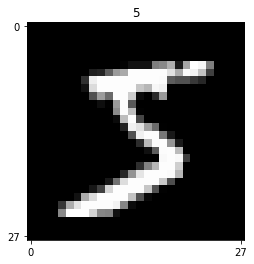

In [14]:
imshow(im);
title(int(target));
xticks([0, im.size[1]-1]);
yticks([0, im.size[0]-1]);

In [15]:
product(im.size)

784

In [16]:
from torchvision import transforms

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [18]:
transform(im).shape

torch.Size([1, 28, 28])

In [19]:
training_data = MNIST('./mndist', train=True,  download=True, transform=transform)

In [20]:
data, target = training_data[0]
print(type(data), target)

<class 'torch.Tensor'> 5


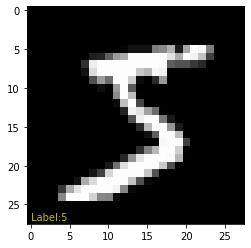

In [21]:
imshow(data.permute(1,2,0))
text(0, 27, f'Label:{target}', c='y');

In [22]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True, num_workers=2)

In [23]:
train_iter = iter(train_loader)
images, targets = train_iter.next()

In [24]:
images.shape

torch.Size([4, 1, 28, 28])

In [25]:
targets.shape

torch.Size([4])

In [26]:
def show_batch(images, targets):
    ncols = int(ceil(sqrt(len(images))))
    nrows = int(ceil(len(images)/ncols))
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].permute(1,2,0))
        xticks([]); yticks([]); 
        if targets is not None:
            xlabel(str(targets[i].numpy()))

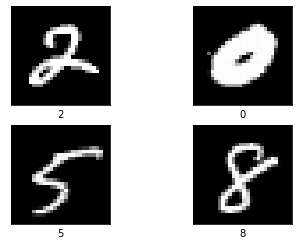

In [27]:
show_batch(images, targets)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [29]:
x = images
x.shape

torch.Size([4, 1, 28, 28])

In [30]:
x = x.flatten(1)
x.shape

torch.Size([4, 784])

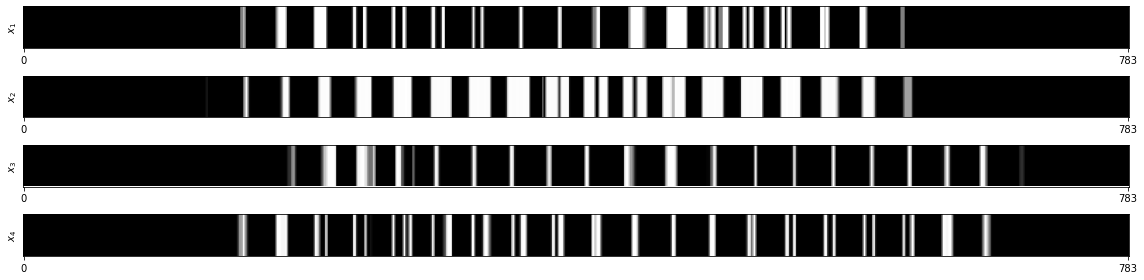

In [98]:
figure(figsize=(16, 4))
for i, xi in enumerate(x, start=1):
    subplot(len(x), 1, i)
    imshow(xi[None], aspect='auto')
    yticks([]);  xticks([0, len(xi)-1])
    ylabel(rf'$x_{i}$')
tight_layout()

In pytorch, every noded of a computation network is an object.  
The object keeps all of its parameters as part of the object's state.  
The object also supports the `__call__` interface which allows it to be used as a function.  

The next cell creates a new function object (module) named `fc` which stands for "fully connected" layer.  
A fully connected layer means that every output depends on every input.  
Mathematically, it is $$y = W\mathbf{x} + \mathbf{b}$$ where $W$ is a general (not necessarily sparse) matrix.

In [31]:
fc = nn.Linear(784, 10)

In [32]:
W, b = fc.parameters()
W.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

Calling the function 'fc(x)' returns an object from the pytorch library.  
The object is called a _tensor_ and it represents an n-dimentional array.   
Tensors also keep a reference to the computation graph that computed them.  
This way, every tensor keeps its own history and we can use that to compute the derivatives of tensors. 

In [48]:
a = fc(x)
a.shape

torch.Size([4, 10])

In [59]:
%conda install -y -q -c anaconda graphviz
%pip install -q torchviz

In [60]:
import torchviz

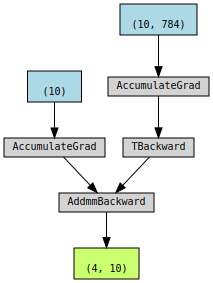

In [61]:
torchviz.make_dot(a)

In addition to the graph needed to compute its gradient, each tensor also tracks
-  A cached gradient tensor -- $\sum \nabla_a f_i$ for any $f_i(a)$ that we have asked torch to differentiate.
-  A current value

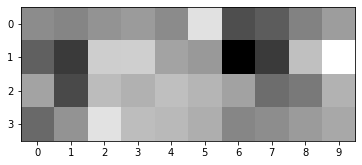

In [63]:
imshow(a.detach(), interpolation='nearest')
xticks(arange(10));

In [64]:
y = a.argmax(1)
y

tensor([5, 9, 4, 2])

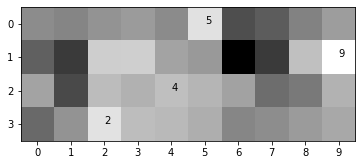

In [65]:
imshow(a.detach(), interpolation='nearest')
xticks(arange(10));
for i, yi in enumerate(y):
    text(yi, i, f'{yi}')

We have not taken any gradients yer

In [69]:
print(a._grad)

None


In [70]:
def show_batch(images, targets, predictions=None):
    ncols = int(ceil(sqrt(len(images))))
    nrows = int(ceil(len(images)/ncols))
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()))
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))


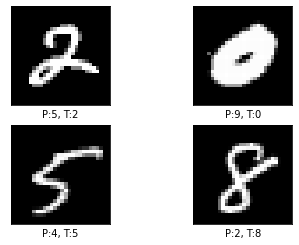

In [71]:
show_batch(images, targets, y)

We can create our _own_ function objects (modules) by extenting `torch.nn.Module`. 

In [100]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.flatten(1)  # flatten domension 1 and higher (4, 1, 27, 27) => (4, 724)
        a = self.fc(x)
        return a   

We do **NOT** override the `__call__` operator because pytorch does some bookkeeping there.   
Pytorch provides the `forward` method as an extension point for us to use.  
The idea is to implement the function using only _modules_ that already exist in pytorch.   
Then pytorch will _automagically_ provide a `backward` method.   
If autodifferentiation wont work or is too inefficient, you can implement `backward` yourself. 

In [101]:
net = MyNet()
net

MyNet(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

Notice that pytorch was able to use _reflection_ in order to determine the modules kept as attributes

All of the parameters that control the behavior of a module are accessible as a `state_dict` dictionary

In [104]:
net.state_dict()

OrderedDict([('fc.weight',
              tensor([[-0.0327, -0.0157,  0.0145,  ..., -0.0186,  0.0135, -0.0298],
                      [ 0.0117,  0.0253, -0.0076,  ...,  0.0186, -0.0131,  0.0234],
                      [-0.0090, -0.0227, -0.0314,  ...,  0.0312, -0.0043,  0.0208],
                      ...,
                      [-0.0235, -0.0142,  0.0252,  ..., -0.0154,  0.0331, -0.0286],
                      [ 0.0342,  0.0002,  0.0013,  ..., -0.0158, -0.0325, -0.0050],
                      [-0.0285,  0.0294,  0.0054,  ...,  0.0229, -0.0307,  0.0175]])),
             ('fc.bias',
              tensor([-0.0110,  0.0170, -0.0234, -0.0348,  0.0244,  0.0217,  0.0148,  0.0166,
                      -0.0275,  0.0077]))])

And also you can iterate over them (without names) using `net.parameters()`

In order to train a net we need a loss function (energy).  
We call this the _criteria_

In [107]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

Neural networks are almost always optimized using a _variant_ of Stocahstic Gradient Descent (SGD).   
SGD and its variants are provided by `torch.optim`.  
The expect an iterator of parameters (wich kepe track of their part of the gradient as mentioned above) and the learning rate.  
Different variants use other parameters.  

In [108]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Will discuss lr and momentum later

The optimizer has a `step` method that does one iteration
$$w = w - \eta \nabla_w E$$
where we assume $\nabla_w E$ is stored in the tensors.  
$\eta$ is the learning rate

Momentum is decribed [here](https://ruder.io/optimizing-gradient-descent/),  but it basically it uses the gradient as an _acceleration_ vector rather than a velocity vector. 

The next cell may take a while to execute

This is not so important on such a small dataset / model, but for larger problems the (linear) time sivings add up. 

In [115]:
log_interval = 500
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 1):
        # get the inputs
        inputs, labels = data

        # zero the cached parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               
        loss = criterion(outputs, labels)   
        loss.backward()                 
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % log_interval == 0:    # print every log_interval mini-batches
            print(f'epoch:{epoch}, iter:{i:5},  loss: {running_loss / log_interval}' )
            running_loss = 0.0

print('Finished Training')


epoch:0, iter:  500,  loss: 0.30238825534284114
epoch:0, iter: 1000,  loss: 0.29248743689944967
epoch:0, iter: 1500,  loss: 0.3065366065537091
epoch:0, iter: 2000,  loss: 0.3053464318793267
epoch:0, iter: 2500,  loss: 0.3036062333993614
epoch:0, iter: 3000,  loss: 0.24704447036143393
epoch:0, iter: 3500,  loss: 0.33464191424893214
epoch:0, iter: 4000,  loss: 0.31752874087775124
epoch:0, iter: 4500,  loss: 0.3243060126765631
epoch:0, iter: 5000,  loss: 0.30786731051048266
epoch:0, iter: 5500,  loss: 0.31717726216150915
epoch:0, iter: 6000,  loss: 0.2958904867172241
epoch:0, iter: 6500,  loss: 0.27514303049701266
epoch:0, iter: 7000,  loss: 0.29931818961165846
epoch:0, iter: 7500,  loss: 0.30025498509872706
epoch:0, iter: 8000,  loss: 0.29287919141515156
epoch:0, iter: 8500,  loss: 0.32035988138942045
epoch:0, iter: 9000,  loss: 0.30784767076931896
epoch:0, iter: 9500,  loss: 0.268956490348326
epoch:0, iter:10000,  loss: 0.30484029555134473
epoch:0, iter:10500,  loss: 0.2843890790315345


In [116]:
y = net(images).argmax(1)

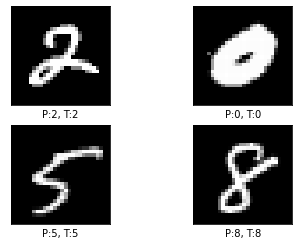

In [117]:
show_batch(images, targets, y)

**ALERT: This was ALL on TRAINING data -- we NEED TEST!!!***

In [118]:
test_data = MNIST('./mndist', train=False,  download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=2)

In [119]:
with torch.no_grad():
    cm = np.zeros((10,10), dtype=np.int64)
    for x, y in iter(test_loader):
        p = net(x).argmax(1).numpy()
        for pred, true in zip(p, y):
            cm[int(pred), int(true)] += 1

In [120]:
import pandas as pd
df_cm = pd.DataFrame(cm, index = arange(10), columns = arange(10))
df_cm

,0,1,2,3,4,5,6,7,8,9
0,965,0,11,3,1,10,14,2,8,12
1,0,1109,8,0,2,3,3,8,6,7
2,2,2,912,20,2,3,4,20,6,2
3,1,2,16,923,2,33,2,8,24,11
4,0,0,13,0,924,9,10,6,9,54
5,3,2,1,23,1,774,17,1,29,13
6,6,4,13,2,13,14,903,0,9,0
7,1,2,15,15,4,7,3,965,14,48
8,2,14,40,19,9,33,2,3,866,9
9,0,0,3,5,24,6,0,15,3,853


Install $\texttt{seaborn}$ to plot confusion matrices (and many other things) easily.   

In [122]:
%pip install -q seaborn 
import seaborn as sn

Note: you may need to restart the kernel to use updated packages.


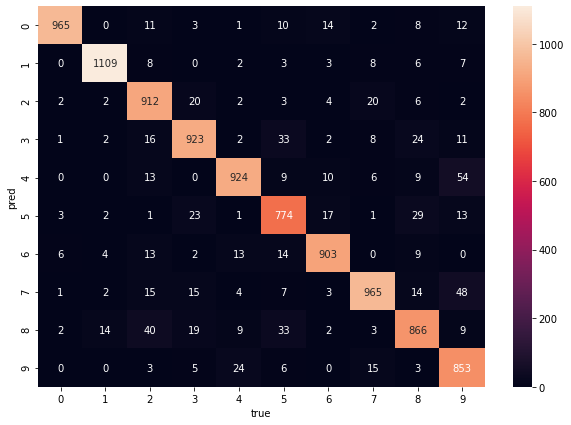

In [123]:
figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='d', annot=True);
ylabel('pred')
xlabel('true');

In [124]:
acc = np.trace(cm)/ np.sum(cm)
acc

0.9194

In [125]:
def report_from_cm(cm, labels, beta=1):
    df = pd.DataFrame(index=list(labels)+['avg/total'], columns=['precision', 'recall', 'fmeasure','support'])
    for i, label in enumerate(labels):
        tp = cm[i,i]
        p = cm[i,:].sum()
        support = cm[:,i].sum()
        fp = p-tp
        fn = support-tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fmeasure = (1+beta**2)*precision*recall/((beta**2)*precision + recall)
        df['precision'][label] = precision
        df['recall'][label] = recall
        df['fmeasure'][label] = fmeasure
        df['support'][label] = support
    df['precision']['avg/total'] = df['precision'][:'avg/total'].mean()
    df['recall']['avg/total'] = df['recall'][:'avg/total'].mean()
    df['fmeasure']['avg/total'] = df['fmeasure'][:'avg/total'].mean()
    df['support']['avg/total'] = df['support'][:'avg/total'].sum()
    return df

In [126]:
report_from_cm(cm, range(10))

,precision,recall,fmeasure,support
0,0.940546,0.984694,0.962114,980
1,0.967714,0.977093,0.972381,1135
2,0.937307,0.883721,0.909726,1032
3,0.903131,0.913861,0.908465,1010
4,0.901463,0.940937,0.920777,982
5,0.895833,0.867713,0.881549,892
6,0.936722,0.942589,0.939646,958
7,0.89851,0.938716,0.918173,1028
8,0.868606,0.889117,0.878742,974
9,0.938394,0.845391,0.889468,1009


# Lab Activity


Modify the training code as follows:
1. (Optional) Add a `torchvision.transforms.Resize` to the transforms to reduce the size of each image (e.g. to 8x8) so that training is fast on your computer.   
1. Keep track of the loss after each checkpoint so that you can plot it when training completes. 
2. At each checkpoint, compute the loss on the evaluation data and save it to a different list so that you can plot bothe the training _and_ the test loss when training completes. 
3. If necessary, increase the number of epochs until you can see that you overfit the data. 
4. Submit **only** a printout of the plot of training vs test loss, and the code for the training loop. 